## Airlines lose tens of billions of dollars annually (at over $30 billion in the U.S. and up to $60-$67 billion globally) due to delays. Can we predict which flights are at risk 24 hours in advance so they can proactively rebook passengers?
#### To start off, we must explore the dataset and analyse it.

In [1]:
import polars as pl # you could use pandas for the same operations if it is more familiar.
 
df = pl.read_csv('data/Airline_Delay_Cause.csv')
df.head()

year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
i64,i64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023,8,"""9E""","""Endeavor Air Inc.""","""ABE""","""Allentown/Bethlehem/Easton, PA…",89.0,13.0,2.25,1.6,3.16,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
2023,8,"""9E""","""Endeavor Air Inc.""","""ABY""","""Albany, GA: Southwest Georgia …",62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2023,8,"""9E""","""Endeavor Air Inc.""","""AEX""","""Alexandria, LA: Alexandria Int…",62.0,10.0,2.73,1.18,1.8,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
2023,8,"""9E""","""Endeavor Air Inc.""","""AGS""","""Augusta, GA: Augusta Regional …",66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
2023,8,"""9E""","""Endeavor Air Inc.""","""ALB""","""Albany, NY: Albany Internation…",92.0,22.0,7.76,0.0,2.96,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [2]:
df.shape

(171666, 21)

In [3]:
df.columns

['year',
 'month',
 'carrier',
 'carrier_name',
 'airport',
 'airport_name',
 'arr_flights',
 'arr_del15',
 'carrier_ct',
 'weather_ct',
 'nas_ct',
 'security_ct',
 'late_aircraft_ct',
 'arr_cancelled',
 'arr_diverted',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

#### Some columns have unclear meanings so I will briefly explain each:
* arr_flights: Total arriving flights
* arr_del15: Arriving flights delayed 15+ minutes
* carrier_ct / weather_ct / nas_ct ... : Flights delayed due to airline carrier / weather / NAS issues.
* arr_cancelled / arr_diverted: Cancelled arriving flights / diverted arriving flights
* carrier_delay / weather_delay / nas_delay ... : Delay minutes due to carrier / weather / NAS.

In [4]:
df.describe()

statistic,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
str,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",171666.0,171666.0,"""171666""","""171666""","""171666""","""171666""",171426.0,171223.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0,171426.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""",240.0,443.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0
"""mean""",2018.551361,6.493633,null,null,null,null,362.528467,66.434387,20.796615,2.250347,19.381147,0.157096,23.770554,7.530497,0.863387,4239.48733,1437.185124,222.563497,920.651704,7.382725,1651.700063
"""std""",2.890006,3.440908,null,null,null,null,992.894662,179.540694,50.315176,7.314252,61.675244,0.717405,72.393477,43.65488,3.772853,12618.56605,4215.677812,821.086511,3423.509335,41.779985,5221.878385
"""min""",2013.0,1.0,"""9E""","""AirTran Airways Corporation""","""ABE""","""Aberdeen, SD: Aberdeen Regiona…",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",2016.0,4.0,null,null,null,null,50.0,6.0,2.16,0.0,1.0,0.0,1.23,0.0,0.0,335.0,110.0,0.0,34.0,0.0,65.0
"""50%""",2019.0,7.0,null,null,null,null,100.0,17.0,6.4,0.4,3.91,0.0,5.0,1.0,0.0,1018.0,375.0,18.0,146.0,0.0,320.0
"""75%""",2021.0,9.0,null,null,null,null,250.0,47.0,17.26,1.86,11.71,0.0,15.26,4.0,1.0,2884.0,1109.0,146.0,477.0,0.0,1070.0
"""max""",2023.0,12.0,"""YX""","""Virgin America""","""YUM""","""Yuma, AZ: Yuma MCAS/Yuma Inter…",21977.0,4176.0,1293.91,266.42,1884.42,58.69,2069.07,4951.0,197.0,438783.0,196944.0,31960.0,112018.0,3760.0,227959.0


In [5]:
print(f"""
      {df['airport_name'].n_unique()} unique airport names, 
      {df['airport'].n_unique()} unique airports, 
      {df['carrier'].n_unique()} unique carriers,
      {df['carrier_name'].n_unique()} unique carrier names
        """)   # Columns with a large number of unique values will need special encoding techniques.


      419 unique airport names, 
      395 unique airports, 
      21 unique carriers,
      23 unique carrier names
        


In [6]:
types = df.dtypes 
for col, dtype in zip(df.columns, types):  
    print(f"{col}: {dtype}")   # The pairs of type:column  must be accurate.

year: Int64
month: Int64
carrier: String
carrier_name: String
airport: String
airport_name: String
arr_flights: Float64
arr_del15: Float64
carrier_ct: Float64
weather_ct: Float64
nas_ct: Float64
security_ct: Float64
late_aircraft_ct: Float64
arr_cancelled: Float64
arr_diverted: Float64
arr_delay: Float64
carrier_delay: Float64
weather_delay: Float64
nas_delay: Float64
security_delay: Float64
late_aircraft_delay: Float64


#### Carefully analyzing the results reveals a few things:

* Nulls exist across most columns, often at a count of 240 (Maybe the same empty columns are causing this issue?)
* There are massive outliers (e.g. max of weather_delay	is 31960 but the 75th percentile value is 146!)
* Some columns like airport name have got a high count of distinct values.

These will be dealt with in the **preprocessing stage**. For now, we can proceed with the exploration.

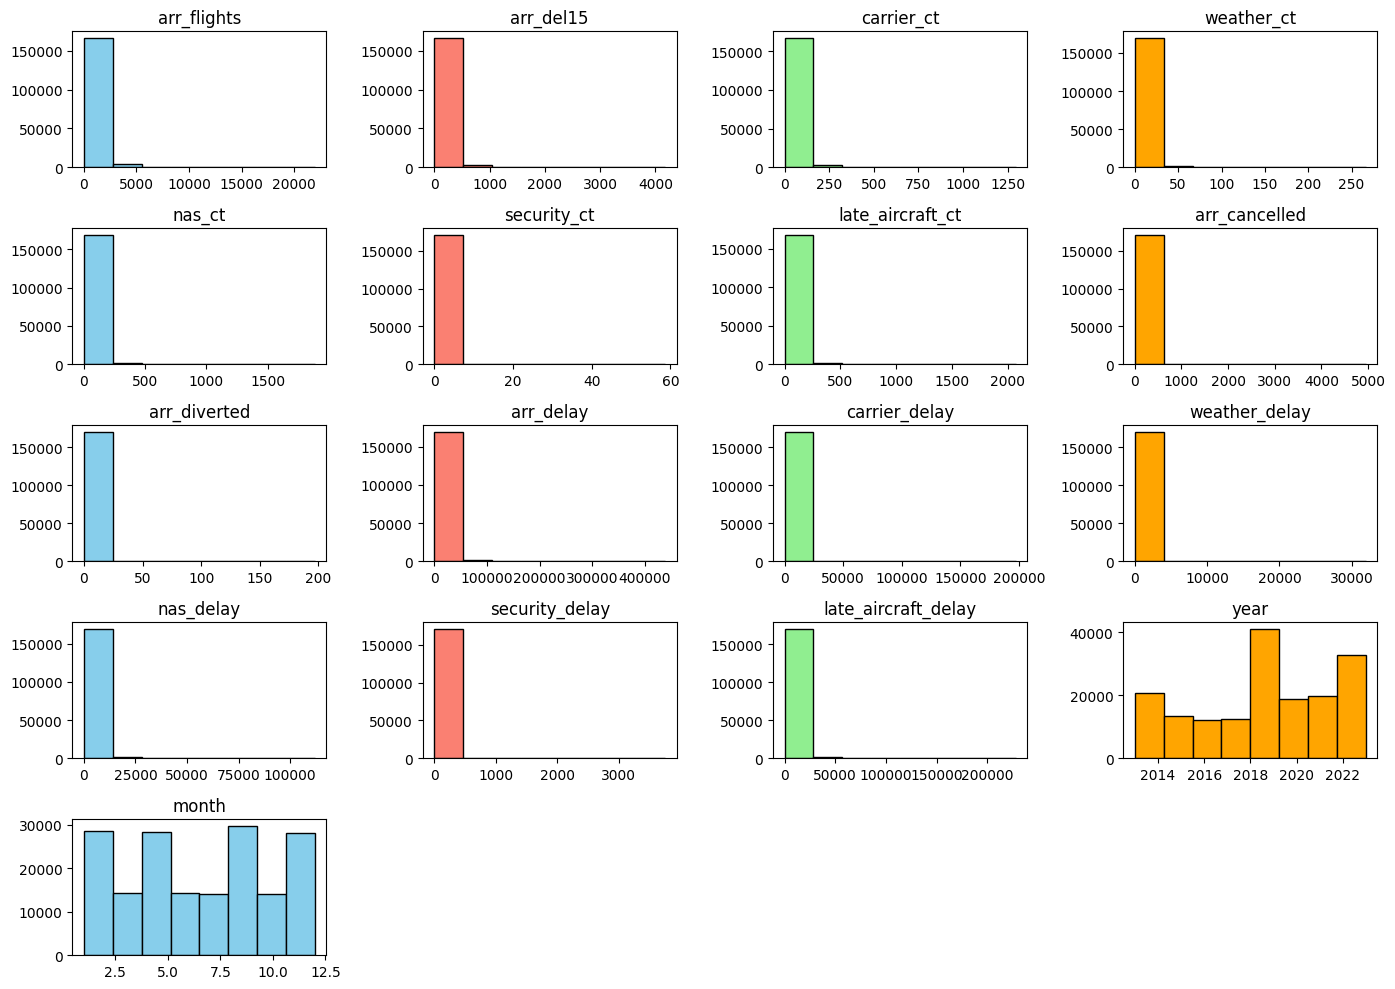

In [7]:
import matplotlib.pyplot as plt

num_cols = (
    df.select(pl.col(pl.Float64)).columns
    + df.select(pl.col(pl.Int64)).columns
)

rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
axes = axes.flatten()

colors = ["skyblue", "salmon", "lightgreen", "orange"]

for i, (ax, col) in enumerate(zip(axes, num_cols)):
    color = colors[i % 4]
    ax.hist(df[col].to_numpy(), bins=8, edgecolor="black", color=color)
    ax.set_title(col)

for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> Features are mostly positively skewed, making log transformations a good consideration. However it is important to note outliers are few, so log transformation **may or may not be all that necessary** say, if we remove outliers.

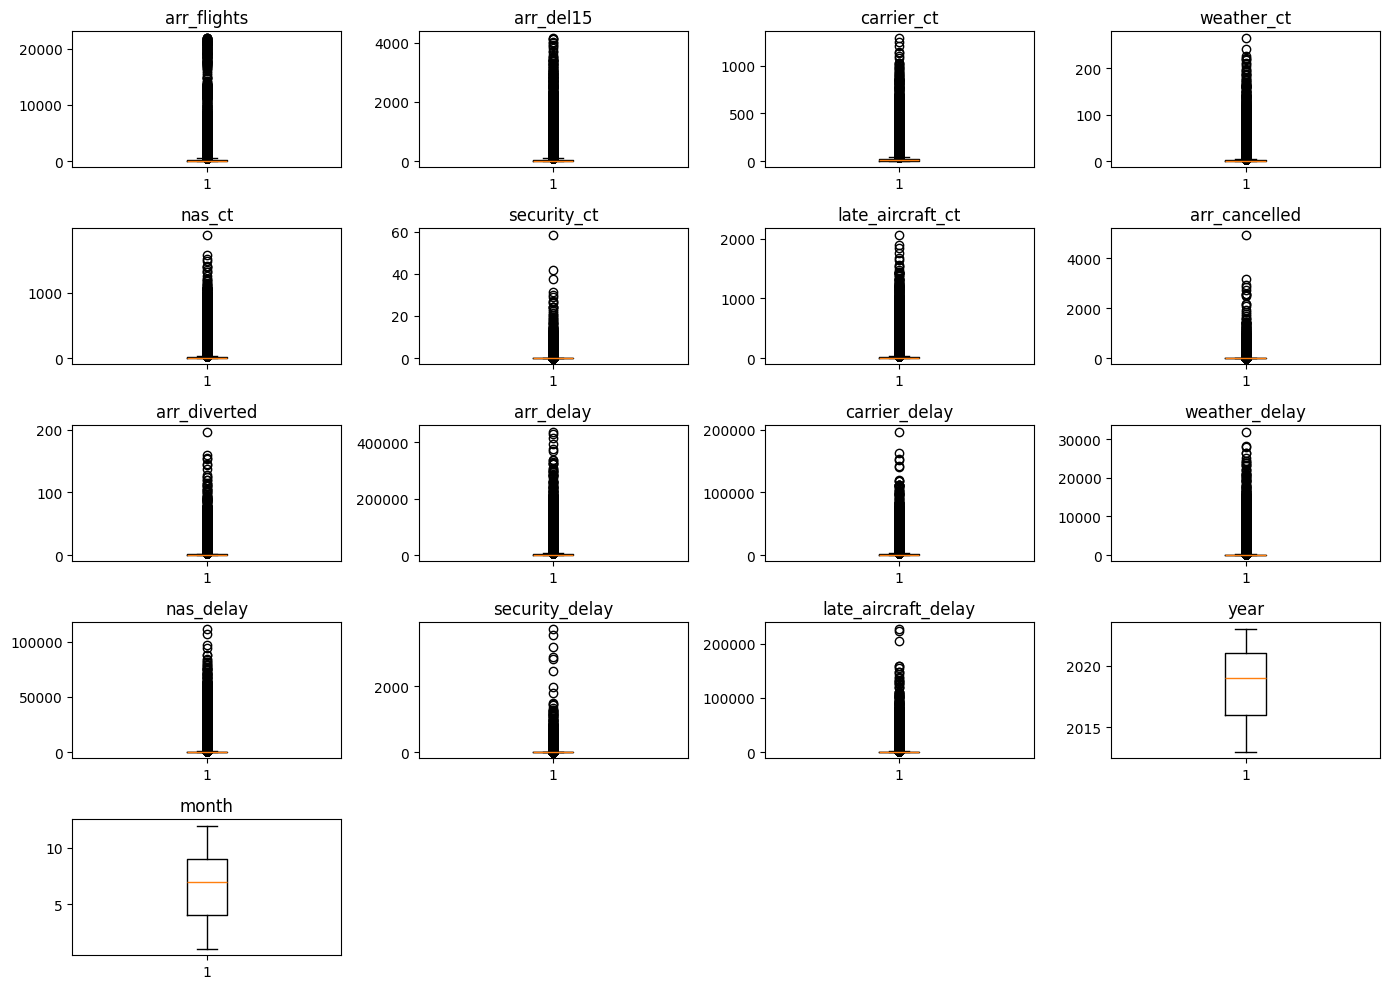

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 4, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    box_data = (  # we must drop nulls momentarily to plot boxplots
    df[col]
    .drop_nulls()
    .drop_nans()
    .to_numpy()
    )
    ax.boxplot(box_data, vert=True)
    ax.set_title(col)

for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> The frequency and distribution of these outliers suggest they are inherent to the data, not mistakes. Thus, removal would be unfair to the true structure of the data.

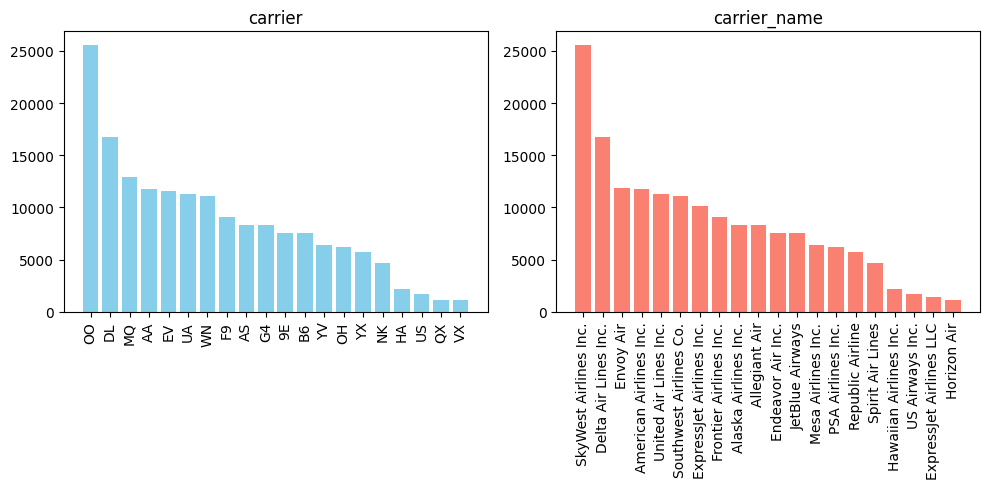

In [9]:
import polars as pl
import matplotlib.pyplot as plt

low_cardinality_cat_cols = ['carrier','carrier_name']
colors = ["skyblue", "salmon"]
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

for ax, col, color in zip(axes, low_cardinality_cat_cols , colors):
    counts = (
        df[col]
        .drop_nulls()
        .value_counts()
        .sort("count", descending=True)
        .head(20)
    )
    
    ax.bar(counts[col].to_list(), counts["count"].to_list(), color=color)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=90)

for ax in axes[len(low_cardinality_cat_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> Some carriers are more rare such as VX. This might not allow our model to learn the true impact of VX 

In [10]:
air_name_counts = df['airport_name'].value_counts()
print(air_name_counts['count'].max())
print(air_name_counts['count'].mean())
print(air_name_counts['count'].median())
print(air_name_counts['count'].min())
print(air_name_counts['count'].n_unique())

1535
409.7040572792363
198.0
1
295


In [11]:
air_counts = df['airport'].value_counts()
print(air_counts['count'].max())
print(air_counts['count'].mean())
print(air_counts['count'].median())
print(air_counts['count'].min())
print(air_counts['count'].n_unique())

1535
434.59746835443036
219.0
1
282


#### The number of unique airport IDs is smaller than that of airport_names, meaning **certain airport names have identical IDs**. 

#### Now that we understand the shapes of our data, we can move on to understanding relationships.

* How have delays fluctuated throughout years and month?

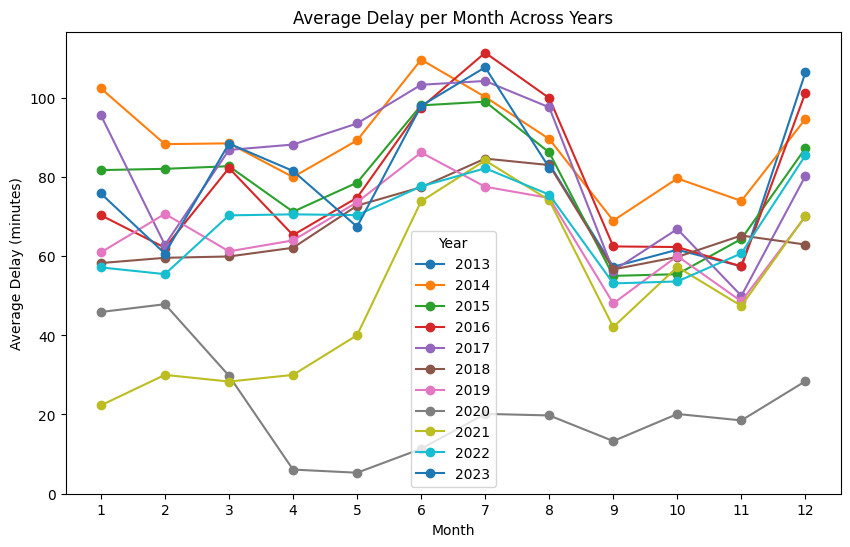

In [12]:
import polars as pl
import matplotlib.pyplot as plt

df_time = (
    df.group_by(['year', 'month'])
      .agg(pl.col('arr_del15').mean().alias('avg_delay'))
      .sort(['year', 'month'])
)


years = df_time.select("year").unique().to_series().to_list()

plt.figure(figsize=(10,6))

for year in years:
    year_data = df_time.filter(pl.col("year") == year).sort("month")
    months = year_data.select("month").to_series().to_list()
    avg_delay = year_data.select("avg_delay").to_series().to_list()
    
    plt.plot(months, avg_delay, marker='o', label=str(year))

plt.title("Average Delay per Month Across Years")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Month")
plt.xticks(range(1,13))
plt.legend(title="Year")
plt.show()


#### --> The year 2020, likely due to covid, saw the least amount of delay and least amount of flights naturally. We could consider making a feature of this but it is unpredictable noise meaning in reality we could never truly predict an event like the Covid outbreak.

* How frequent are delays across carriers, relative to that carrier's frequency in the dataset?

C:\Users\User\AppData\Local\Temp\ipykernel_17928\2234899793.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


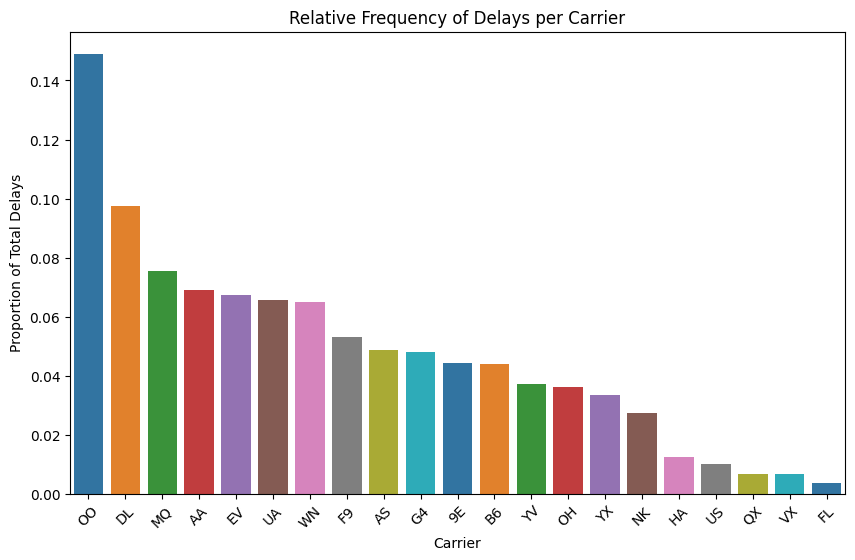

In [13]:
import seaborn as sns

df_carrier = (
    df.group_by('carrier')
      .agg(pl.count('arr_del15').alias('num_delays'))
)

total_delays = df_carrier['num_delays'].sum()
df_carrier = df_carrier.with_columns(
    (pl.col('num_delays') / total_delays).alias('rel_freq')
).sort('rel_freq', descending=True)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_carrier.to_pandas(), 
    x='carrier', 
    y='rel_freq', 
    palette="tab10"
)
plt.title("Relative Frequency of Delays per Carrier")
plt.ylabel("Proportion of Total Delays")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()


#### --> Specific carriers have more delay than others.

* How frequent are delays across airports, relative to that airports' frequency in the dataset?

C:\Users\User\AppData\Local\Temp\ipykernel_17928\4162408271.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


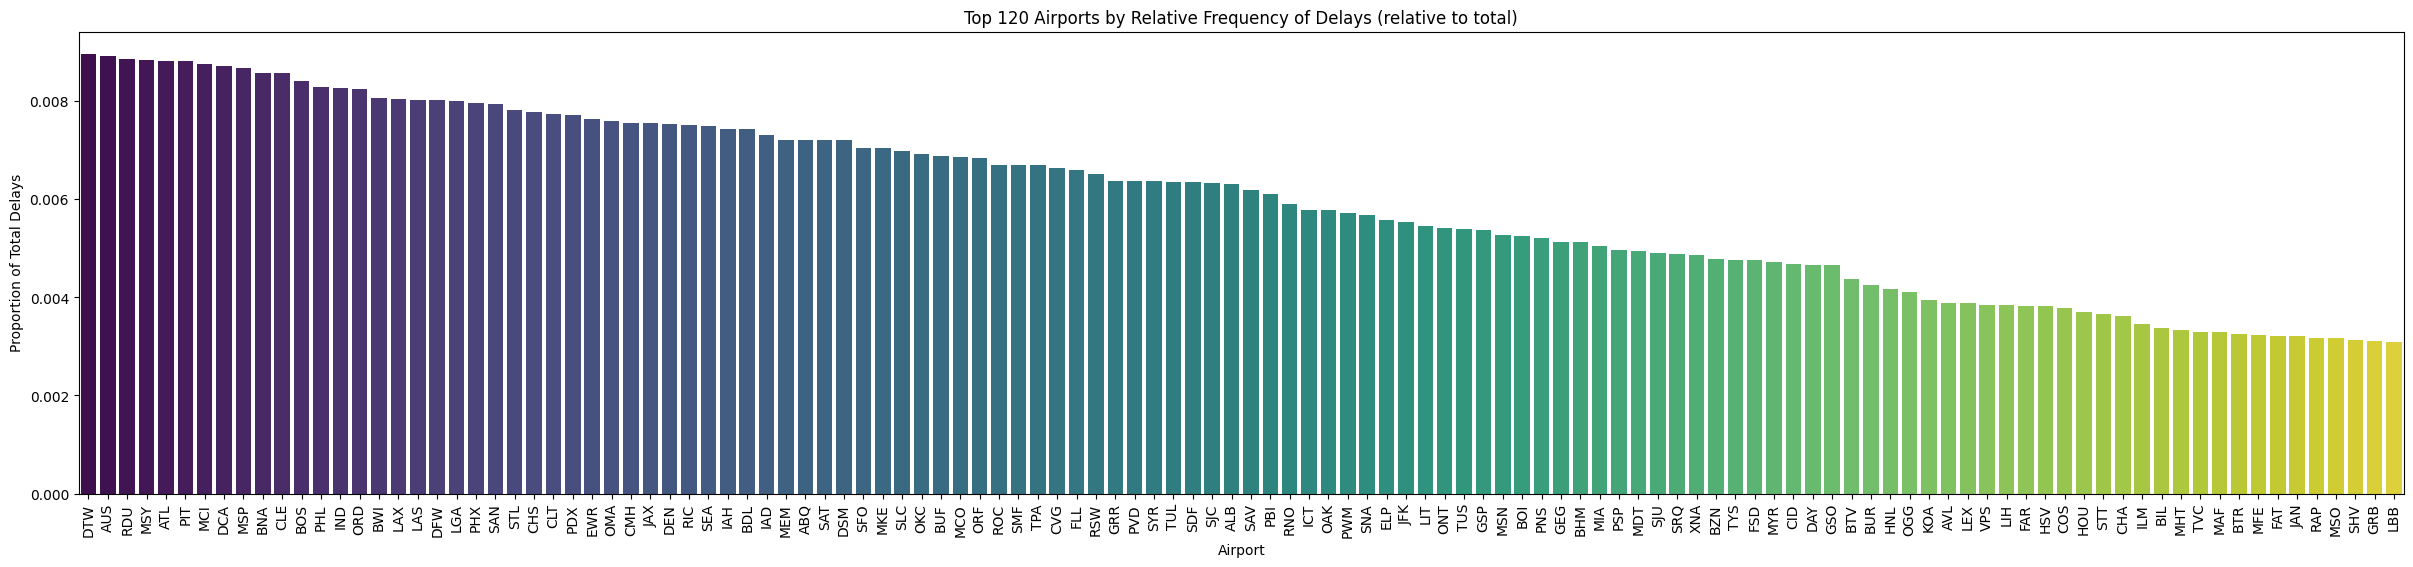

In [14]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

df_airport = (
    df.group_by('airport')
      .agg(pl.count('arr_del15').alias('num_delays'))
      .sort('num_delays', descending=True)
      .head(120)
)

total_delays = df.select(pl.count('arr_del15')).to_series()[0]

df_airport = df_airport.with_columns(
    (pl.col('num_delays') / total_delays).alias('rel_freq')
)

plt.figure(figsize=(30,6))
sns.barplot(
    data=df_airport.to_pandas(),
    x='airport',
    y='rel_freq',
    palette="viridis"
)
plt.title("Top 120 Airports by Relative Frequency of Delays (relative to total)")
plt.ylabel("Proportion of Total Delays")
plt.xlabel("Airport")
plt.xticks(rotation=90)
plt.show()


#### --> Specific airports have more delay than others.

### Our EDA reveals that this dataset is **rich in signal**, in other words, delay isn't the result of random noise.